In [63]:
# Missing installs in requirements.txt
# h5py, pandas, matplotlib
# Numpy conflict: solved by `conda install numpy=1.20`

# /home/timsey/anaconda3/envs/c2st/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
#   return torch._C._cuda_getDeviceCount() > 0

In [64]:
# On remote run:
# rsync -arm tbbakke@ivi-h0.science.uva.nl:/home/tbbakke/c2st-e/results/mri/NAME_OF_FOLDER /home/timsey/Projects/c2st-e/results/ivi_results/mri/

In [65]:
# RUNNING:
# Meta: 200, 400, 800, 1000, 2000 on IvI
# Base: 200 on IvI
# Base: 400, 800, 1000, 2000, 3000, 4000, 5000 on Local

# Next day:
# Meta seems almost done.
# Base taking a while... 1K, 2K, 3K done, 200 on IvI as well. 4K running on local, 5K, 400 and 800 still to go.
# Will run 400 and 800 on IvI now: will have to remove these from the results folder on Local to 
#  not double count if the run gets there before tomorrow. Jupyter code can read from
#  partial (i.e results_size1000.json), so just removing (or moving!) results.json 
#  (and all the results_size400.json, etc.) should work.

In [66]:
# New model params (eps, sigma, sigma0_u)
#  dataset_size = 5000: 1000 train, 250 val, 1250 test.
#   val:     val_loss = -9.1335e-15, mmd2 = 9.1551e-19, varEst = 4.7101e-11, Kxyxy.shape = [250 x 250] (full batch).
#    NOTE: varEst lower than 1e-8, which is the margin factor in the sqrt for the loss.
#   train: train_loss = -1.4601e-13, Kxyxy.shape = [64 x 64] or [40 x 40] (batched) --> hardly any training.
#   val:     val_loss = -1.8280e-14, mmd2 = 1.8323e-18, varEst = 4.7101e-11, Kxyxy.shape = [250 x 250] (full batch).
#   test:   test_loss = -2.0786e-14, mmd2 = 2.0797e-18, varEst = 1.0697e-11, Kxyxy.shape = [1250 x 1250] (full batch)

In [67]:
# Old model params (eps, sigma, sigma0_u)
#  dataset_size = 5000: 1000 train, 250 val, 1250 test.
#   val:     val_loss = 0.,  mmd2 = 0., varEst = 8.4219e-5, Kxyxy.shape = [250 x 250] (full batch): same as epoch 1 (below).
#   train: train_loss = -7.5692e-18, Kxyxy.shape = [64 x 64] or [40 x 40] (batched) --> hardly any training.
#   val:     val_loss = 0.,  mmd2 = 0., varEst = 8.4219e-5, Kxyxy.shape = [250 x 250] (full batch): same as epoch 0 (above).
#   test:   test_loss = -0., mmd2 = 0., varEst = 1.9054e-6, Kxyxy.shape = [1250 x 1250] (full batch)

In [68]:
import logging
from pprint import pprint
import time
import os
import pickle
import random
import xml.etree.ElementTree as etree
from pathlib import Path
from typing import (
    Any,
    Callable,
    Dict,
    List,
    NamedTuple,
    Optional,
    Sequence,
    Tuple,
    Union,
)
from warnings import warn

import h5py
import numpy as np
import pandas as pd
import requests
import torch
import yaml
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
import torch.fft

from collections import defaultdict
from functools import partial
from torch.distributions import Normal

# import seaborn as sns
# sns.set_style("darkgrid")

import json
from scipy.stats import combine_pvalues

print(torch.__version__)

1.7.0+cu101


In [69]:
save_figs = True
save_dir = Path("/home/timsey/Projects/c2st-e/results/mri_figs")

In [70]:
# TODO: Cluster? 2GPU for big models?
# - Meta can maybe fit? Why though, batches of test and train are saturated.
# - Guess just try it split up enough that it might work?

# Reading the results

In [86]:
results_base_dir = Path("/home/timsey/Projects/c2st-e/results/")
results_name = "results.json"

# Base results: individual experiments, all settings, multiple sizes
# Old
# results_datetimes = ["mri/2022-09-23/18:09:04"]
# New
results_datetimes = ["mri/base_exp_oct10/2022-10-10/14:43:24", "ivi_results/mri/base_exp_oct10_ivi/2022-10-10/16:16:23"]

results_dict = {}
for results_datetime in results_datetimes:
    results_path = results_base_dir / results_datetime / results_name
    try:
        with open(results_path, 'r') as f:
            partial_results = json.load(f)
        results_dict.update(partial_results)
    except FileNotFoundError:
        print("`results.json` not found, looking for individual results instead...")
        for fn in results_path.parent.iterdir():
            if fn.name.startswith("results"):
                dataset_size = fn.name.split(".")[0].split("_")[1][4:]
                with open(fn, 'r') as f:
                    partial_results = json.load(f)
                results_dict.update({dataset_size: partial_results})

# Check resulting dict
num_runs = 100  # Number of runs per dataset size expected
for key, val in results_dict.items():
    print(f"Dataset size: {key}, {len(val)} runs.")
    # Assume 100 values, 3 settings
    assert len(val[str(num_runs - 1)]) == 3

`results.json` not found, looking for individual results instead...
Dataset size: 1000, 100 runs.
Dataset size: 3000, 100 runs.
Dataset size: 2000, 100 runs.
Dataset size: 200, 100 runs.



1000 points, 100 samples.
Fraction of E-values > 1: 0.98


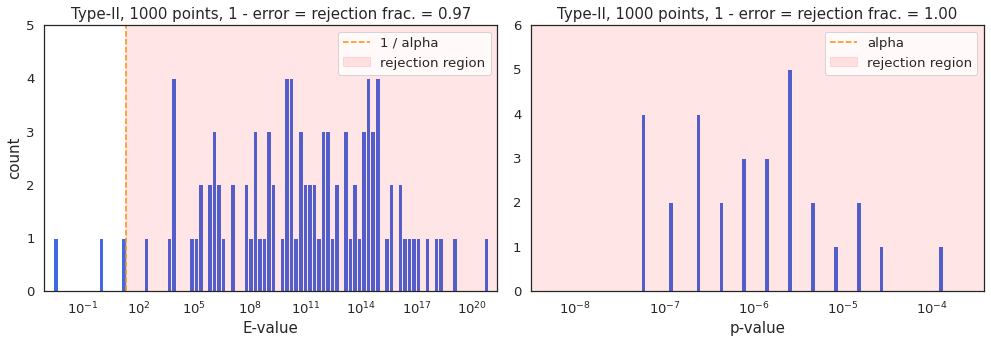

{'1a': {'e_error': 0.0, 'p_error': 0.02, 'pl_error': 0.01},
 '1b': {'e_error': 0.02, 'p_error': 0.04, 'pl_error': 0.04},
 '2': {'e_error': 0.030000000000000027, 'p_error': 0.0, 'pl_error': 0.0}}

3000 points, 100 samples.
{'1a': {'e_error': 0.0, 'p_error': 0.1, 'pl_error': 0.08},
 '1b': {'e_error': 0.0, 'p_error': 0.05, 'pl_error': 0.02},
 '2': {'e_error': 0.0, 'p_error': 0.0, 'pl_error': 0.0}}

2000 points, 100 samples.
{'1a': {'e_error': 0.0, 'p_error': 0.05, 'pl_error': 0.09},
 '1b': {'e_error': 0.0, 'p_error': 0.03, 'pl_error': 0.03},
 '2': {'e_error': 0.0, 'p_error': 0.0, 'pl_error': 0.0}}

200 points, 100 samples.
Fraction of E-values > 1: 0.71


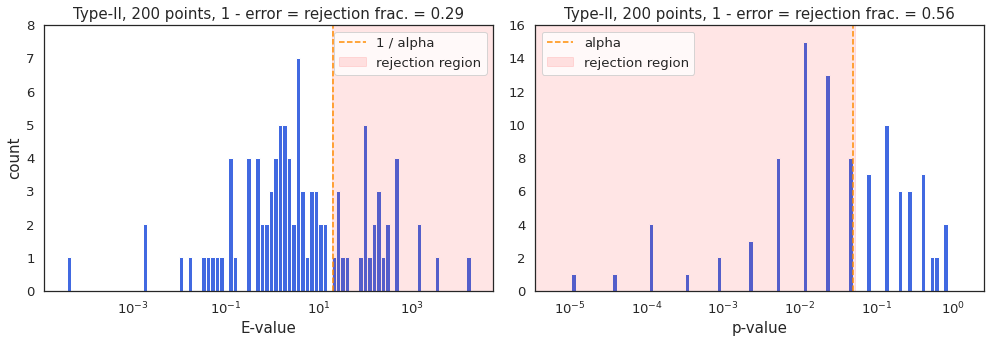

{'1a': {'e_error': 0.0, 'p_error': 0.02, 'pl_error': 0.04},
 '1b': {'e_error': 0.0, 'p_error': 0.03, 'pl_error': 0.05},
 '2': {'e_error': 0.71, 'p_error': 0.43999999999999995, 'pl_error': 0.52}}


In [87]:
# Compute Type-I and Type-II errors for given dataset size.

alpha = 0.05  # Threshold
errors_per_size = {}
for dataset_size, ds_dict in results_dict.items():
    e_vals = defaultdict(list)
    p_vals = defaultdict(list)
    pl_vals = defaultdict(list)
    print(f"\n{dataset_size} points, {len(ds_dict)} samples.")
    for dataset_ind, di_dict in ds_dict.items():
        for setting, set_dict in di_dict.items():
            e_vals[setting].append(set_dict["e_val"])
            p_vals[setting].append(set_dict["p_val"])
            pl_vals[setting].append(set_dict.get("p_val_l", 0))  # p_val_ls (sigmoid)
#             test_loss = setting["test_loss"]
#             test_acc = setting["test_acc"]
   
    if dataset_size in ["200", "400", "1000"]:
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        type2_evals = np.array(e_vals['2'])
        reject_frac = ((1 / type2_evals) < alpha).mean()
        print("Fraction of E-values > 1:", (type2_evals > 1).mean())
        # Plot the 10-log
        logmin = np.log(np.min(type2_evals)) / np.log(10) - 0.5
        logmax = np.log(np.max(type2_evals)) / np.log(10) + 0.5
        n, bins, patches = plt.hist(
            type2_evals.astype(np.float128), bins=np.logspace(logmin, logmax, 101), color="royalblue"
        )
        plt.axvline(1 / alpha, linestyle="--", label="1 / alpha", color="darkorange")
        plt.fill_between(
            np.logspace(np.log(1 / alpha) - 1.71, logmax, 10),  # why 1.71 though?
            np.zeros(10), 
            np.max(n) * np.ones(10) + 1, 
            color="red", 
            alpha=0.1, 
            label="rejection region",
        )
        plt.title(f"Type-II, {dataset_size} points, 1 - error = rejection frac. = {reject_frac:.2f}", fontsize=15)
        plt.legend()
        plt.xscale('log')
        plt.xlim(10**logmin, 10**logmax)
        plt.ylim(0, np.max(n) + 1)
        plt.ylabel("count", fontsize=15)
        plt.xlabel("E-value", fontsize=15)
        
        plt.subplot(1, 2, 2)
        type2_pvals = np.array(p_vals['2'])
        reject_frac = (type2_pvals < alpha).mean()
        # Plot the 10-log
        logmin = np.log(np.min(type2_pvals) + 1e-8) / np.log(10) - 0.5
        logmax = np.log(np.max(type2_pvals)) / np.log(10) + 0.5
        n, bins, patches = plt.hist(
            type2_pvals.astype(np.float128), bins=np.logspace(logmin, logmax, 100), color="royalblue"
        )
        plt.axvline(alpha, linestyle="--", label="alpha", color="darkorange")
        plt.fill_between(
            np.logspace(logmin, np.log(alpha) + 1.71, 10),  # why 1.71 though?
            np.zeros(10), 
            np.max(n) * np.ones(10) + 1, 
            color="red", 
            alpha=0.1, 
            label="rejection region",
        )
        plt.title(f"Type-II, {dataset_size} points, 1 - error = rejection frac. = {reject_frac:.2f}", fontsize=15)
        plt.legend()
        plt.xscale('log')
        plt.xlim(10**logmin, 10**logmax)
        plt.ylim(0, np.max(n) + 1)
        plt.xlabel("p-value", fontsize=15)
        plt.tight_layout()
        plt.show()
    
    errors_per_setting = {}
    for setting in e_vals.keys():
        # 0 if accept, 1 if reject
        e_decisions = (1 / np.array(e_vals[setting])) < alpha
        p_decisions = np.array(p_vals[setting]) < alpha
        pl_decisions = np.array(pl_vals[setting]) < alpha
        if setting in ["1a", "1b"]:  # Type-I error
            # Rejection of null is incorrect
            e_error = e_decisions.sum() / len(e_decisions)
            p_error = p_decisions.sum() / len(p_decisions)
            pl_error = pl_decisions.sum() / len(pl_decisions)
        elif setting == "2":  # Type-II error
            # Rejection of null is correct
            e_error = 1 - e_decisions.sum() / len(e_decisions)
            p_error = 1 - p_decisions.sum() / len(p_decisions)
            pl_error = 1 - pl_decisions.sum() / len(pl_decisions)
        else:
            raise ValueError("Unknown setting.")
            
        errors_per_setting[setting] = {"e_error": e_error, "p_error": p_error, "pl_error": pl_error}
    pprint(errors_per_setting)
    
    errors_per_size[dataset_size] = errors_per_setting

In [10]:
# # Bar plots per error
# dataset_sizes = np.array([int(key) for key in errors_per_size.keys()])
# plot_sizes = dataset_sizes / 1000

# plt.figure(figsize=(16, 5))
# width = 0.08

# plt.subplot(1, 3, 1)
# plt.title("Type-1a error", fontsize=18)
# e_error1a = [val["1a"]["e_error"] for val in errors_per_size.values()]
# p_error1a = [val["1a"]["p_error"] for val in errors_per_size.values()]
# plt.bar(plot_sizes-width/2, e_error1a, width=width, label="E-value", color="darkorange")
# plt.bar(plot_sizes+width/2, p_error1a, width=width, label="p-value", color="royalblue")
# plt.legend()
# plt.ylabel("error value", fontsize=15)
# plt.xlabel("dataset size (x1000)", fontsize=15)

# plt.subplot(1, 3, 2)
# plt.title("Type-1b error", fontsize=18)
# e_error1b = [val["1b"]["e_error"] for val in errors_per_size.values()]
# p_error1b = [val["1b"]["p_error"] for val in errors_per_size.values()]
# plt.bar(plot_sizes-width/2, e_error1b, width=width, label="E-value", color="darkorange")
# plt.bar(plot_sizes+width/2, p_error1b, width=width, label="p-value", color="royalblue")
# plt.legend()
# plt.ylabel("error value", fontsize=15)
# plt.xlabel("dataset size (x1000)", fontsize=15)

# plt.subplot(1, 3, 3)
# plt.title("Type-2 error", fontsize=18)
# e_error2 = [val["2"]["e_error"] for val in errors_per_size.values()]
# p_error2 = [val["2"]["p_error"] for val in errors_per_size.values()]
# plt.bar(plot_sizes-width/2, e_error2, width=width, label="E-value", color="darkorange")
# plt.bar(plot_sizes+width/2, p_error2, width=width, label="p-value", color="royalblue")
# plt.legend()
# plt.ylabel("error value", fontsize=15)
# plt.xlabel("dataset size (x1000)", fontsize=15)

# plt.tight_layout()
# plt.show()

In [11]:
# Violin plots: what do we actually want to plot here? Only have single error per setting, so we want to 
# plot individual E-/p-values?
# They vary a lot across the 100 samples though (see some of the histograms two cells up); we would use log space.
# Histograms might be more informative than violin plot.

# plt.figure(figsize=(15, 4))

# p_error1a = [val["1a"]["p_error"] for val in errors_per_size.values()]

# sizes = list(sorted(errors_per_size.keys(), key=lambda x: int(x)))
# max_cols = 4
# cols = min(max_cols, len(sizes))
# rows = len(sizes) // cols + 1 if len(sizes) % cols != 0 else len(sizes) // cols

# xs = ["E-1a", "p-1a", "E-1b", "p-1b", "E-2", "p-2"]
# for i, size in enumerate(sizes):
#     plt.subplot(rows, cols, i+1)
#     e_error1a = errors_per_size[size]["1a"]["e_error"]
#     p_error1a = errors_per_size[size]["1a"]["p_error"]
#     e_error1b = errors_per_size[size]["1b"]["e_error"]
#     p_error1b = errors_per_size[size]["1b"]["p_error"]
#     e_error2 = errors_per_size[size]["2"]["e_error"]
#     p_error2 = errors_per_size[size]["2"]["p_error"]
    
#     vp = plt.violinplot(
#         [e_error1a, p_error1a, e_error1b, p_error1b, e_error2, p_error2], 
#         widths=0.6, 
#         showmeans=True, 
#         showextrema=True,
#     )

#     plt.title(f"Dataset size: {size}", fontsize=15)
#     plt.xticks(xs, bar_labels)
#     plt.ylabel("error value", fontsize=15)
#     for i, pc in enumerate(vp["bodies"]):
#         if i == 0:
#             pc.set_facecolor("darkorange")
#         else:
#             pc.set_facecolor("royalblue")

# plt.tight_layout()
# plt.show()

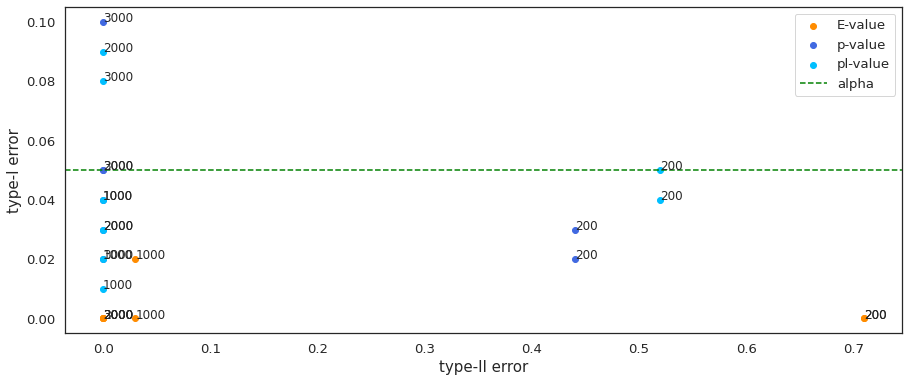

In [88]:
# Scatter plot for Pareto front

plt.figure(figsize=(15, 6))

ex, ey1, ey2, px, py1, py2 = [], [], [], [], [], []
plx, ply1, ply2 = [], [], []
for size, vals in errors_per_size.items():
    e1a = vals["1a"]["e_error"]
    e1b = vals["1b"]["e_error"]
    e2 = vals["2"]["e_error"]
    ex.append(e2)
    ey1.append(e1a)
    ey2.append(e1b)
    
    p1a = vals["1a"]["p_error"]
    p1b = vals["1b"]["p_error"]
    p2 = vals["2"]["p_error"]
    px.append(p2)
    py1.append(p1a)
    py2.append(p1b)
    
    pl1a = vals["1a"]["pl_error"]
    pl1b = vals["1b"]["pl_error"]
    pl2 = vals["2"]["pl_error"]
    plx.append(pl2)
    ply1.append(pl1a)
    ply2.append(pl1b)
    
    plt.annotate(f"{size}", (e2, e1a), fontsize=12)
    plt.annotate(f"{size}", (e2, e1b), fontsize=12)
    plt.annotate(f"{size}", (p2, p1a), fontsize=12)
    plt.annotate(f"{size}", (p2, p1b), fontsize=12)
    plt.annotate(f"{size}", (pl2, pl1a), fontsize=12)
    plt.annotate(f"{size}", (pl2, pl1b), fontsize=12)

plt.scatter(ex, ey1, label="E-value", c="darkorange")
plt.scatter(ex, ey2, label="E-value", c="darkorange")

plt.scatter(px, py1, label="p-value", c="royalblue")
plt.scatter(px, py2, label="p-value", c="royalblue")

plt.scatter(plx, ply1, label="pl-value", c="deepskyblue")
plt.scatter(plx, ply2, label="pl-value", c="deepskyblue")

plt.axhline(y=alpha, label="alpha", linestyle="--", c="green")

plt.xlabel("type-II error", fontsize=15)
plt.ylabel("type-I error", fontsize=15)
# Make sure labels are not duplicated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

if save_figs:
    plot_save_dir = save_dir
    plot_save_dir.mkdir(parents=True, exist_ok=True)
    save_name = f"mri_pareto_front"
    plt.savefig(plot_save_dir / (save_name + ".pdf"), dpi=300)
    plt.savefig(plot_save_dir / (save_name + ".svg"), dpi=300)
    plt.savefig(plot_save_dir / (save_name + ".png"), dpi=300)
    
plt.show()

In [89]:
df_dict = {
    "Type I error": [],
    "Type II error": [],
    "Dataset": [],
    "Size": [],
    "Label": [],
    "Comparison": [],    
}

for size, vals in errors_per_size.items():
    size = int(size) // 4  # test data size is N / 4.
    
    e1a = vals["1a"]["e_error"]
    e1b = vals["1b"]["e_error"]
    e2 = vals["2"]["e_error"]
    
    p1a = vals["1a"]["p_error"]
    p1b = vals["1b"]["p_error"]
    p2 = vals["2"]["p_error"]
    
    pl1a = vals["1a"]["pl_error"]
    pl1b = vals["1b"]["pl_error"]
    pl2 = vals["2"]["pl_error"]
    
    # Add an E for every comparison, add two rows per comparison (type1a and 1b)
    
    # Add E1
    df_dict["Type I error"].extend([e1a, e1b])
    df_dict["Type II error"].extend([e2, e2])
    df_dict["Dataset"].extend(["Dataset 1", "Dataset 2"])
    df_dict["Size"].extend([size, size])
    df_dict["Label"].extend(["E-C2ST", "E-C2ST"])
    df_dict["Comparison"].extend(["E-C2ST, S-C2ST", "E-C2ST, S-C2ST"])  
    # Add P
    df_dict["Type I error"].extend([p1a, p1b])
    df_dict["Type II error"].extend([p2, p2])  # twice the same
    df_dict["Dataset"].extend(["Dataset 1", "Dataset 2"])
    df_dict["Size"].extend([size, size])
    df_dict["Label"].extend(["S-C2ST", "S-C2ST"])
    df_dict["Comparison"].extend(["E-C2ST, S-C2ST", "E-C2ST, S-C2ST"])
    
    # Add E2
    df_dict["Type I error"].extend([e1a, e1b])
    df_dict["Type II error"].extend([e2, e2])
    df_dict["Dataset"].extend(["Dataset 1", "Dataset 2"])
    df_dict["Size"].extend([size, size])
    df_dict["Label"].extend(["E-C2ST", "E-C2ST"])
    df_dict["Comparison"].extend(["E-C2ST, L-C2ST", "E-C2ST, L-C2ST"])
    # Add P-L
    df_dict["Type I error"].extend([pl1a, pl1b])
    df_dict["Type II error"].extend([pl2, pl2])  # twice the same
    df_dict["Dataset"].extend(["Dataset 1", "Dataset 2"])
    df_dict["Size"].extend([size, size])
    df_dict["Label"].extend(["L-C2ST", "L-C2ST"])
    df_dict["Comparison"].extend(["E-C2ST, L-C2ST", "E-C2ST, L-C2ST"])

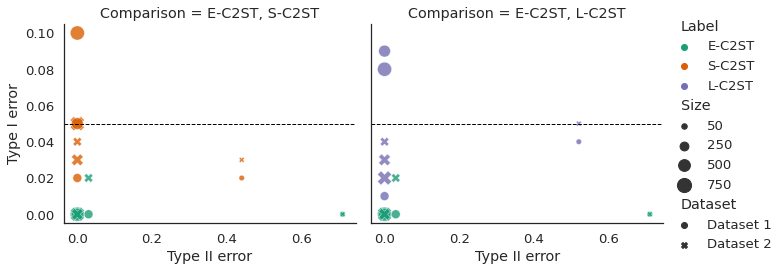

In [90]:
import seaborn as sns

df = pd.DataFrame(df_dict)
labels = ["E-C2ST", "S-C2ST", "L-C2ST"]

sns.set(font_scale=1.5)
sns.set_theme(style="white",font_scale=1.2)
g=sns.relplot(
    data=df,
    x="Type II error", y="Type I error", col="Comparison",
    hue="Label", hue_order=labels, style="Dataset", size="Size", sizes=(30, 200), palette="Dark2", height=4,
    aspect=1.2, alpha=0.8,
)
for ax in g.axes.flat:
    ax.axhline(alpha, linestyle="--", c = "black",linewidth=1)
# plt.savefig("face_comparison.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

## Meta-analysis experiments

In [43]:
# # 100 samples, sizes (200, 400, 1K), Type-II
# meta_analysis_folder = Path("/home/timsey/Projects/c2st-e/results/mri/meta_analysis_sept26/")
# # 100 samples, sizes (200, 400, 1K), Type-Ia&1b
# meta_analysis_folder = Path("/home/timsey/Projects/c2st-e/results/mri/meta_analysis_sept27")

# all_results_dicts = []
# for date_folder in meta_analysis_folder.iterdir():
#     for time_folder in date_folder.iterdir():
#         results_file = time_folder / "results.json"
#         if not results_file.exists():
#             print(f"Missing results folder in: {time_folder}")
#             continue

#         with open(results_file, 'r') as f:
#             results_dict = json.load(f)
#         all_results_dicts.append(results_dict)

# print(len(all_results_dicts))

In [91]:
# # 100 samples, sizes (200, 400, 1K), Type-II
# meta_analysis_folder2 = Path("/home/timsey/Projects/c2st-e/results/mri/meta_analysis_sept26/")
# # 100 samples, sizes (200, 400, 1K), Type-Ia&1b
# meta_analysis_folder1 = Path("/home/timsey/Projects/c2st-e/results/mri/meta_analysis_sept27")
# meta_analysis_folders = [meta_analysis_folder1, meta_analysis_folder2]

meta_analysis_folders = [Path("/home/timsey/Projects/c2st-e/results/ivi_results/mri/meta_analysis_oct10_ivi")]

all_results_dicts = []
for meta_analysis_folder in meta_analysis_folders:
    for date_folder in meta_analysis_folder.iterdir():
        for time_folder in date_folder.iterdir():
            results_file = time_folder / "results.json"
            if not results_file.exists():
                print(f"Missing results folder in: {time_folder}")
                continue

            with open(results_file, 'r') as f:
                results_dict = json.load(f)
            all_results_dicts.append(results_dict)

print(len(all_results_dicts))

Missing results folder in: /home/timsey/Projects/c2st-e/results/ivi_results/mri/meta_analysis_oct10_ivi/2022-10-11/12:49:34
492


In [92]:
# Compute Type-I and Type-II errors per experiment (over n partitions), and
# also compute E-value of the combined partitions (meta-analysis).

alpha = 0.05  # Threshold

meta_analysis_dict = defaultdict(dict)
for i, results_dict in enumerate(all_results_dicts):
#     print(f"Experiment {i+1}/{len(all_results_dicts)}")
    for dataset_size, ds_dict in results_dict.items():
        e_vals = defaultdict(list)
        p_vals = defaultdict(list)
        pl_vals = defaultdict(list)
#         print(f"{dataset_size} points, {len(ds_dict)} partitions.")
        for partition_ind, partition_dict in ds_dict.items():
            # Each ind is now a partition
            for setting, set_dict in partition_dict.items():
                e_vals[setting].append(set_dict["e_val"])
                p_vals[setting].append(set_dict["p_val"])
                pl_vals[setting].append(set_dict.get("p_val_l", 0))
    #             test_loss = setting["test_loss"]
    #             test_acc = setting["test_acc"]

        errors_per_setting = {}
        for setting in e_vals.keys():
            # 0 if accept, 1 if reject
            e_decisions = (1 / np.array(e_vals[setting])) < alpha
            p_decisions = np.array(p_vals[setting]) < alpha
            pl_decisions = np.array(pl_vals[setting]) < alpha
            if setting in ["1a", "1b"]:  # Type-I error
                # Rejection of null is incorrect
                e_error = e_decisions.sum() / len(e_decisions)
                p_error = p_decisions.sum() / len(p_decisions)
                pl_error = pl_decisions.sum() / len(pl_decisions)
            elif setting == "2":  # Type-II error
                # Rejection of null is correct
                e_error = 1 - e_decisions.sum() / len(e_decisions)
                p_error = 1 - p_decisions.sum() / len(p_decisions)
                pl_error = 1 - pl_decisions.sum() / len(pl_decisions)
            else:
                raise ValueError("Unknown setting.")

#             print("Individual E-values:", e_vals[setting])
            p_fisher_stat, comb_p_value = combine_pvalues(p_vals[setting])
            pl_fisher_stat, comb_pl_value = combine_pvalues(pl_vals[setting])
            errors_per_setting[setting] = {
                "e_error_indiv": e_error,  # E-value error computed over partitions (by treating them as different experiments)
                "p_error_indiv": p_error,  # Same, but for p-value
                "pl_error_indiv": pl_error,
                "e_value_prod": np.prod(e_vals[setting]),  # Combine E-values: multiplication over all partitions (experiments)
                "e_value_avg": np.mean(e_vals[setting]),
                "p_value_comb": comb_p_value,  # Combine p-values over partitions using Fisher combination
                "pl_value_comb": comb_pl_value,
            }
    
#         pprint(errors_per_setting)
        meta_analysis_dict[dataset_size][i] = errors_per_setting
#         print(meta_analysis_dict)

/home/timsey/anaconda3/envs/ml/lib/python3.7/site-packages/scipy/stats/stats.py:6895: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


In [93]:
# Use the product E-values as new E-value, and compute error over M samples of the whole N-partition experiment.

e_prod_errors_per_size = defaultdict(dict)

for dataset_size, sample_dict in meta_analysis_dict.items():
    indiv_e_errors = defaultdict(list)
    indiv_p_errors = defaultdict(list)
    indiv_pl_errors = defaultdict(list)
    prod_e_values = defaultdict(list)
    avg_e_values = defaultdict(list)
    comb_p_values = defaultdict(list)
    comb_pl_values = defaultdict(list)
    for sample_ind, settings_dict in sample_dict.items():
        for setting, error_dict in settings_dict.items():
            e_error_indiv = error_dict["e_error_indiv"]
            p_error_indiv = error_dict["p_error_indiv"]
            pl_error_indiv = error_dict["pl_error_indiv"]
            e_value_prod = error_dict["e_value_prod"]
            e_value_avg = error_dict["e_value_avg"]
            p_value_comb = error_dict["p_value_comb"]
            pl_value_comb = error_dict["pl_value_comb"]
            indiv_e_errors[setting].append(e_error_indiv)
            indiv_p_errors[setting].append(p_error_indiv)
            indiv_pl_errors[setting].append(pl_error_indiv)
            prod_e_values[setting].append(e_value_prod)
            avg_e_values[setting].append(e_value_avg)
            comb_p_values[setting].append(p_value_comb)
            comb_pl_values[setting].append(pl_value_comb)
    
    for setting, prod_es in prod_e_values.items():
        comb_p = comb_p_values[setting]
        comb_pl = comb_pl_values[setting]
        # 0 if accept, 1 if reject
        e_decisions = (1 / np.array(prod_es)) < alpha
        e_decisions_by_avg = (1 / np.array(avg_e_values[setting])) < alpha
        p_decisions = np.array(comb_p) < alpha
        pl_decisions = np.array(comb_pl) < alpha
        if setting in ["1a", "1b"]:  # Type-I error
            # Rejection of null is incorrect
            e_error = e_decisions.sum() / len(e_decisions)
            e_error_by_avg = e_decisions_by_avg.sum() / len(e_decisions_by_avg)
            p_error = p_decisions.sum() / len(p_decisions)
            pl_error = pl_decisions.sum() / len(pl_decisions)
        elif setting == "2":  # Type-II error
            # Rejection of null is correct
            e_error = 1 - e_decisions.sum() / len(e_decisions)
            e_error_by_avg = 1 - e_decisions_by_avg.sum() / len(e_decisions_by_avg)
            p_error = 1 - p_decisions.sum() / len(p_decisions)
            pl_error = 1 - pl_decisions.sum() / len(pl_decisions)
        else:
            raise ValueError("Unknown setting.")

        e_prod_errors_per_size[dataset_size][setting] = {
            "prod_e_error": e_error,
            "avg_e_error": e_error_by_avg,  # Error using average of experiment E-value instead of product
            "comb_p_error": p_error,
            "comb_pl_error": pl_error,
            "indiv_e_error_hist": indiv_e_errors[setting],
            "indiv_p_error_hist": indiv_p_errors[setting],
            "indiv_pl_error_hist": indiv_pl_errors[setting],
        }

In [94]:
# dataset_sizes = list(e_prod_errors_per_size.values())
# num_sizes = len(dataset_sizes)

# settings = list(list(e_prod_errors_per_size.values())[0].keys())
# num_settings = len(settings)

# plt.figure(figsize=(6*num_sizes, 4*num_settings))
# plt.suptitle("Histograms of errors.", fontsize=18)
# for i, (dataset_size, size_results) in enumerate(e_prod_errors_per_size.items()):
#     for j, (setting, setting_results) in enumerate(size_results.items()):
#         plt.subplot(num_settings, num_sizes, num_sizes*j+i+1)
#         plt.hist(setting_results["indiv_e_error_hist"], bins=np.arange(0, 1.01, 1/11), label="E-value", color="darkorange", alpha=0.5)
#         plt.hist(setting_results["indiv_p_error_hist"], bins=np.arange(0, 1.01, 1/11), label="p-value", color="royalblue", alpha=0.5)
    
#         plt.title(f"Type-{setting} errors ({dataset_size} points).", fontsize=15)
#         plt.xlabel("error value", fontsize=15)
#         if i == 0:
#             plt.ylabel("error count", fontsize=15)
#         plt.legend()
    
# plt.tight_layout(rect=[0, 0.03, 1, 0.98])
# plt.show()

In [95]:
# settings = list(list(e_prod_errors_per_size.values())[0].keys())
# num_settings = len(settings)

# plt.figure(figsize=(12, 4*num_settings))
# plt.suptitle(f"Meta-analysis: {int(partition_ind) + 1} partitions ({len(all_results_dicts)} samples).", fontsize=18)
# for i, setting in enumerate(settings):
#     bar_labels = []
#     e_error_vals = []
#     p_error_vals = []
#     e_error_vals_indiv_avg = []
#     p_error_vals_indiv_avg = []
#     for dataset_size, results in e_prod_errors_per_size.items():
#         bar_labels.append(dataset_size)
#         e_error_vals.append(results[setting]["prod_e_error"])
#         p_error_vals.append(results[setting]["comb_p_error"])
#         e_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_e_error_hist"]))
#         p_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_p_error_hist"]))
    
#     width=0.2
#     xs = np.array(list(range(len(e_error_vals))))
    
#     plt.subplot(num_settings, 2, 2*i+1)
#     plt.bar(xs-width/2, e_error_vals, width=width, label="E-value (comb)", color="navajowhite")
#     plt.bar(xs+width/2, e_error_vals_indiv_avg, width=width, label="E-value (indiv)", color="darkorange")
#     plt.title(f"E-value type-{setting} errors", fontsize=15)
#     plt.xlabel("dataset size", fontsize=15)
#     plt.xticks(xs, bar_labels)
#     plt.ylabel("error value", fontsize=15)
#     plt.ylim(0, .1)
#     plt.legend()
    
#     plt.subplot(num_settings, 2, 2*i+2)
#     plt.bar(xs-width/2, p_error_vals, width=width, label="p-value (comb)", color="deepskyblue")
#     plt.bar(xs+width/2, p_error_vals_indiv_avg, width=width, label="p-value (indiv)", color="royalblue")
#     plt.title(f"p-value type-{setting} errors", fontsize=15)
#     plt.xlabel("dataset size", fontsize=15)
#     plt.xticks(xs, bar_labels)
#     plt.ylim(0, 1)
#     plt.legend()
    
# plt.tight_layout(rect=[0, 0.03, 1, 0.98])
# plt.show()

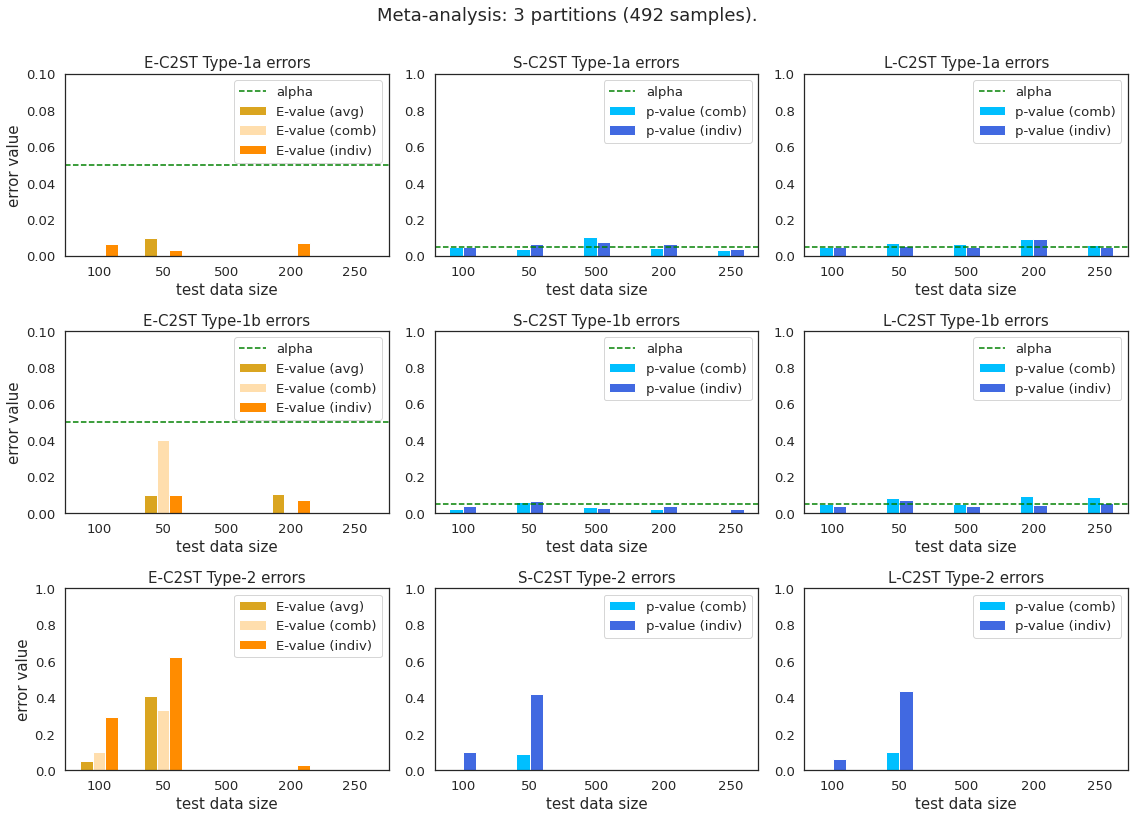

In [96]:
settings = list(list(e_prod_errors_per_size.values())[0].keys())
num_settings = len(settings)

plt.figure(figsize=(16, 4*num_settings))
plt.suptitle(f"Meta-analysis: {int(partition_ind) + 1} partitions ({len(all_results_dicts)} samples).", fontsize=18)
for i, setting in enumerate(settings):
    bar_labels = []
    e_error_vals = []
    e_by_avg_error_vals = []
    p_error_vals = []
    pl_error_vals = []
    e_error_vals_indiv_avg = []
    p_error_vals_indiv_avg = []
    pl_error_vals_indiv_avg = []
    for dataset_size, results in e_prod_errors_per_size.items():
        dataset_size = int(dataset_size) // 4
        bar_labels.append(dataset_size)
        e_error_vals.append(results[setting]["prod_e_error"])
        e_by_avg_error_vals.append(results[setting]["avg_e_error"])
        p_error_vals.append(results[setting]["comb_p_error"])
        pl_error_vals.append(results[setting]["comb_pl_error"])
        e_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_e_error_hist"]))
        p_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_p_error_hist"]))
        pl_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_pl_error_hist"]))
    
    width=0.2
    xs = np.array(list(range(len(e_error_vals))))
    
    plt.subplot(num_settings, 3, 3*i+1)
    if "1" in setting:
        plt.axhline(y=alpha, linestyle="--", c="green", label="alpha")
    plt.bar(xs-width, e_by_avg_error_vals, width=width, label="E-value (avg)", color="goldenrod")
    plt.bar(xs, e_error_vals, width=width, label="E-value (comb)", color="navajowhite")
    plt.bar(xs+width, e_error_vals_indiv_avg, width=width, label="E-value (indiv)", color="darkorange")
    plt.title(f"E-C2ST Type-{setting} errors", fontsize=15)
    plt.xlabel("test data size", fontsize=15)
    plt.xticks(xs, bar_labels)
    plt.ylabel("error value", fontsize=15)
    if setting == "2":
        plt.ylim(0, 1)
    else:
        plt.ylim(0, 0.1)
    plt.legend()
    
    plt.subplot(num_settings, 3, 3*i+2)
    if "1" in setting:
        plt.axhline(y=alpha, linestyle="--", c="green", label="alpha")
    plt.bar(xs-width/2, p_error_vals, width=width, label="p-value (comb)", color="deepskyblue")
    plt.bar(xs+width/2, p_error_vals_indiv_avg, width=width, label="p-value (indiv)", color="royalblue")
    plt.title(f"S-C2ST Type-{setting} errors", fontsize=15)
    plt.xlabel("test data size", fontsize=15)
    plt.xticks(xs, bar_labels)
    plt.ylim(0, 1)
    plt.legend()
    
    plt.subplot(num_settings, 3, 3*i+3)
    if "1" in setting:
        plt.axhline(y=alpha, linestyle="--", c="green", label="alpha")
    plt.bar(xs-width/2, pl_error_vals, width=width, label="p-value (comb)", color="deepskyblue")
    plt.bar(xs+width/2, pl_error_vals_indiv_avg, width=width, label="p-value (indiv)", color="royalblue")
    plt.title(f"L-C2ST Type-{setting} errors", fontsize=15)
    plt.xlabel("test data size", fontsize=15)
    plt.xticks(xs, bar_labels)
    plt.ylim(0, 1)
    plt.legend()
    
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

if save_figs:
    plot_save_dir = save_dir
    plot_save_dir.mkdir(parents=True, exist_ok=True)
    save_name = f"mri_meta_{'_'.join(settings)}_withavg"
    plt.savefig(plot_save_dir / (save_name + ".pdf"), dpi=300)
    plt.savefig(plot_save_dir / (save_name + ".svg"), dpi=300)
    plt.savefig(plot_save_dir / (save_name + ".png"), dpi=300)
    
plt.show()

In [39]:
settings

['1a', '1b', '2']

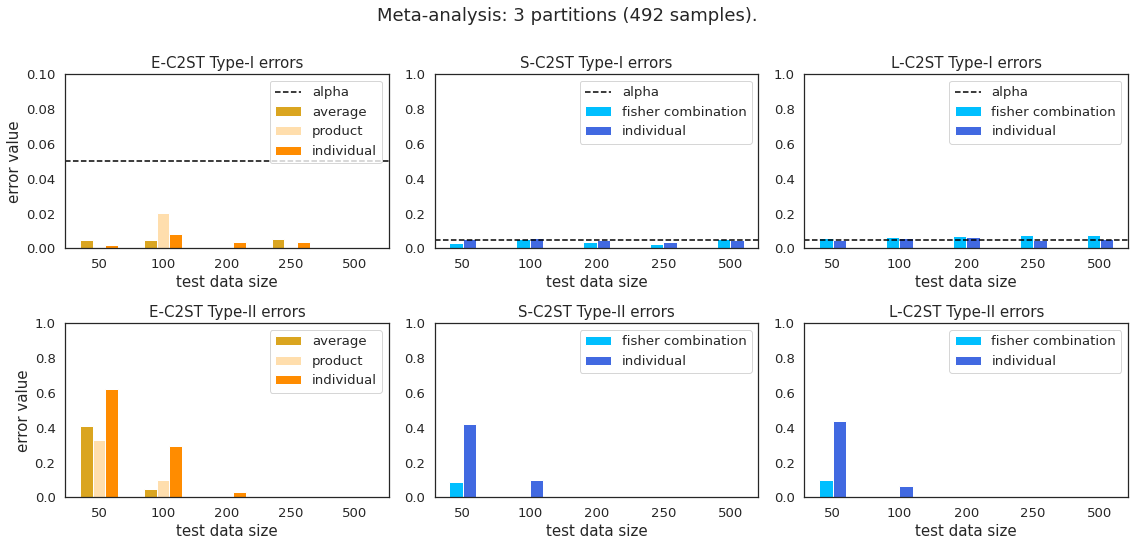

In [100]:
# Now with Type-1 error statistics combined

settings = ["1a", "1b", "2"]
num_settings = len(settings) - 1

plt.figure(figsize=(16, 4*num_settings))
plt.suptitle(f"Meta-analysis: {int(partition_ind) + 1} partitions ({len(all_results_dicts)} samples).", fontsize=18)
seen_1s = 0
for i, setting in enumerate(settings):
    if setting == "2" or ("1" in setting and seen_1s == 0):
        bar_labels = []
        e_error_vals = []
        e_by_avg_error_vals = []
        p_error_vals = []
        pl_error_vals = []
        e_error_vals_indiv_avg = []
        p_error_vals_indiv_avg = []
        pl_error_vals_indiv_avg = []
    for j, (dataset_size, results) in enumerate(e_prod_errors_per_size.items()):
        dataset_size = int(dataset_size) // 4
        if setting == "2" or ("1" in setting and seen_1s == 0):
            bar_labels.append(dataset_size)
            e_error_vals.append(results[setting]["prod_e_error"])
            e_by_avg_error_vals.append(results[setting]["avg_e_error"])
            p_error_vals.append(results[setting]["comb_p_error"])
            pl_error_vals.append(results[setting]["comb_pl_error"])
            e_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_e_error_hist"]))
            p_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_p_error_hist"]))
            pl_error_vals_indiv_avg.append(np.mean(results[setting]["indiv_pl_error_hist"]))
        else:
            # Combine Type1 error stuff: take previous value, add new value, divide by 2
            # This is fine, because all the error computations are linear
            e_error_vals[j] = (e_error_vals[j] + results[setting]["prod_e_error"]) / 2
            e_by_avg_error_vals[j] = (e_by_avg_error_vals[j] + results[setting]["avg_e_error"]) / 2
            
            p_error_vals[j] = (p_error_vals[j] + results[setting]["comb_p_error"]) / 2
            pl_error_vals[j] = (pl_error_vals[j] + results[setting]["comb_pl_error"]) / 2

            e_error_vals_indiv_avg[j] = (e_error_vals_indiv_avg[j] + np.mean(results[setting]["indiv_e_error_hist"])) / 2
            p_error_vals_indiv_avg[j] = (p_error_vals_indiv_avg[j] + np.mean(results[setting]["indiv_p_error_hist"])) / 2
            pl_error_vals_indiv_avg[j] = (pl_error_vals_indiv_avg[j] + np.mean(results[setting]["indiv_pl_error_hist"])) / 2
    
    width=0.2
    xs = np.array(list(range(len(e_error_vals))))
    sorter = np.argsort([int(blabel) for blabel in bar_labels])
    
    # Sort stuff
    bar_labels = np.array(bar_labels)[sorter]
    e_error_vals = np.array(e_error_vals)[sorter]
    e_by_avg_error_vals = np.array(e_by_avg_error_vals)[sorter]
    p_error_vals = np.array(p_error_vals)[sorter]
    pl_error_vals = np.array(pl_error_vals)[sorter]
    e_error_vals_indiv_avg = np.array(e_error_vals_indiv_avg)[sorter]
    p_error_vals_indiv_avg = np.array(p_error_vals_indiv_avg)[sorter]
    pl_error_vals_indiv_avg = np.array(pl_error_vals_indiv_avg)[sorter]
    
    if "1" in setting:
        if seen_1s == 0:
            seen_1s += 1
            # Wait for next loop to complete Type-I error info
            continue
        elif seen_1s == 1:            
            # Plot combined Type-I error
            plt.subplot(num_settings, 3, 1)

            plt.bar(xs-width, e_by_avg_error_vals, width=width, label="average", color="goldenrod")
            plt.bar(xs, e_error_vals, width=width, label="product", color="navajowhite")
            plt.bar(xs+width, e_error_vals_indiv_avg, width=width, label="individual", color="darkorange")
            plt.axhline(y=alpha, linestyle="--", c="black", label="alpha")
            plt.title(f"E-C2ST Type-I errors", fontsize=15)
            plt.xlabel("test data size", fontsize=15)
            plt.xticks(xs, bar_labels)
            plt.ylabel("error value", fontsize=15)
            plt.ylim(0, 0.1)
            plt.legend(loc="upper right")
            
            plt.subplot(num_settings, 3, 2)

            plt.bar(xs-width/2, p_error_vals, width=width, label="fisher combination", color="deepskyblue")
            plt.bar(xs+width/2, p_error_vals_indiv_avg, width=width, label="individual", color="royalblue")
            plt.axhline(y=alpha, linestyle="--", c="black", label="alpha")
            plt.title(f"S-C2ST Type-I errors", fontsize=15)
            plt.xlabel("test data size", fontsize=15)
            plt.xticks(xs, bar_labels)
            plt.ylim(0, 1)
            plt.legend(loc="upper right")
    
            plt.subplot(num_settings, 3, 3)
            plt.bar(xs-width/2, pl_error_vals, width=width, label="fisher combination", color="deepskyblue")
            plt.bar(xs+width/2, pl_error_vals_indiv_avg, width=width, label="individual", color="royalblue")
            plt.axhline(y=alpha, linestyle="--", c="black", label="alpha")
            plt.title(f"L-C2ST Type-I errors", fontsize=15)
            plt.xlabel("test data size", fontsize=15)
            plt.xticks(xs, bar_labels)
            plt.ylim(0, 1)
            plt.legend(loc="upper right")
        else:
            raise RunTimeError()
    else:
        plt.subplot(num_settings, 3, 4)
        plt.bar(xs-width, e_by_avg_error_vals, width=width, label="average", color="goldenrod")
        plt.bar(xs, e_error_vals, width=width, label="product", color="navajowhite")
        plt.bar(xs+width, e_error_vals_indiv_avg, width=width, label="individual", color="darkorange")
        plt.title(f"E-C2ST Type-II errors", fontsize=15)
        plt.xlabel("test data size", fontsize=15)
        plt.xticks(xs, bar_labels)
        plt.ylabel("error value", fontsize=15)
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
    
        plt.subplot(num_settings, 3, 5)
        plt.bar(xs-width/2, p_error_vals, width=width, label="fisher combination", color="deepskyblue")
        plt.bar(xs+width/2, p_error_vals_indiv_avg, width=width, label="individual", color="royalblue")
        plt.title(f"S-C2ST Type-II errors", fontsize=15)
        plt.xlabel("test data size", fontsize=15)
        plt.xticks(xs, bar_labels)
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
            
        plt.subplot(num_settings, 3, 6)
        plt.bar(xs-width/2, pl_error_vals, width=width, label="fisher combination", color="deepskyblue")
        plt.bar(xs+width/2, pl_error_vals_indiv_avg, width=width, label="individual", color="royalblue")
        plt.title(f"L-C2ST Type-II errors", fontsize=15)
        plt.xlabel("test data size", fontsize=15)
        plt.xticks(xs, bar_labels)
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
    
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

if save_figs:
    plot_save_dir = save_dir
    plot_save_dir.mkdir(parents=True, exist_ok=True)
    save_name = f"mri_meta_1comb_{'_'.join(settings)}_withavg"
    plt.savefig(plot_save_dir / (save_name + ".pdf"), dpi=300)
    plt.savefig(plot_save_dir / (save_name + ".svg"), dpi=300)
    plt.savefig(plot_save_dir / (save_name + ".png"), dpi=300)
    
plt.show()

In [ ]:
# Table for meta analysis?

In [50]:
# rsync -a timsey@146.50.28.109:~/Projects/c2st-e/results/mri_figs/ ~/Projects/c2st-e/results/mri_figs/

# Code that is now in PyCharm

In [ ]:
# fastMRI, NeurIPS2020 splits
fastmri_data_folder = Path("/home/timsey/HDD/data/fastMRI/singlecoil")
train = fastmri_data_folder / "singlecoil_train"
val = fastmri_data_folder / "singlecoil_val"
test = fastmri_data_folder / "singlecoil_test"

# fastMRI+
plus_data_folder = Path("/home/timsey/Projects/fastmri-plus/Annotations/")
pathology_path = plus_data_folder / "knee.csv"
checked_path = plus_data_folder / "knee_file_list.csv"

# Skip final row because it's "Knee data" for some reason
pathology_df = pd.read_csv(pathology_path, index_col=None, header=0)
check_df = pd.read_csv(checked_path, names=["file"], index_col=None, header=None, skipfooter=1)

### Dataframe for which volume is clean and which isn't

In [ ]:
def get_pathology_info(folders_to_check, pathology_df, check_df):
    not_checked = defaultdict(bool)
    no_pathologies = defaultdict(bool)
    any_pathologies = defaultdict(bool)
    
    all_pathologies = set([])

    for folder in folders_to_check:
        for fname in folder.iterdir():
            name = fname.name[:-3]
            if name in not_checked or name in no_pathologies or name in any_pathologies:
                raise RunTimeError("Found volume in multiple partitions!")

            if name not in check_df["file"].values:
                not_checked[name] = 1
                continue
            
            pathologies = pathology_df[pathology_df["file"] == name]
            all_pathologies = all_pathologies | set(pathologies["label"].values)
            num_pathologies = len(pathologies)
            if num_pathologies == 0:
                no_pathologies[name] = True
            else:
                any_pathologies[name] = False
    return not_checked, no_pathologies, any_pathologies, list(all_pathologies)

folders_to_check = [train, val, test]
not_checked, no_pathologies, any_pathologies, all_pathologies = get_pathology_info(
    folders_to_check, pathology_df, check_df
)
print(len(not_checked), len(no_pathologies), len(any_pathologies))
print(len(all_pathologies), all_pathologies)

if len(not_checked) == 0:
    clean_volumes = {**no_pathologies, **any_pathologies}
else:
    clean_volumes = None
    raise NotImplementedError("Haven't thought of what to do if there are unchecked volumes yet.")

In [ ]:
def et_query(
    root: etree.Element,
    qlist,
    namespace: str = "http://www.ismrm.org/ISMRMRD",
) -> str:
    """
    ElementTree query function.
    This can be used to query an xml document via ElementTree. It uses qlist
    for nested queries.
    Args:
        root: Root of the xml to search through.
        qlist: A list of strings for nested searches, e.g. ["Encoding",
            "matrixSize"]
        namespace: Optional; xml namespace to prepend query.
    Returns:
        The retrieved data as a string.
    """
    s = "."
    prefix = "ismrmrd_namespace"

    ns = {prefix: namespace}

    for el in qlist:
        s = s + f"//{prefix}:{el}"

    value = root.find(s, ns)
    if value is None:
        raise RuntimeError("Element not found")

    return str(value.text)


class FastMRIRawDataSample(NamedTuple):
    fname: Path
    slice_ind: int
    metadata: Dict[str, Any]
    slice_pathologies: Sequence[str]
        
        
class PathologiesSliceDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(
        self,
        root: Union[str, Path, os.PathLike],
        challenge: str,
        transform: Optional[Callable] = None,
        use_dataset_cache: bool = False,
        sample_rate: Optional[float] = None,
        volume_sample_rate: Optional[float] = None,
        dataset_cache_file: Union[str, Path, os.PathLike] = "dataset_cache.pkl",
        num_cols: Optional[Tuple[int]] = None,
        raw_sample_filter: Optional[Callable] = None,
        pathology_df: Optional[pd.DataFrame] = None,
        clean_volumes: Optional[dict] = None,
        use_center_slices_only: Optional[bool] = None,
        seed: Optional[int] = None,
    ):
        """
        Args:
            root: Path to the dataset.
            challenge: "singlecoil" or "multicoil" depending on which challenge
                to use.
            transform: Optional; A callable object that pre-processes the raw
                data into appropriate form. The transform function should take
                'kspace', 'target', 'attributes', 'filename', and 'slice' as
                inputs. 'target' may be null for test data.
            use_dataset_cache: Whether to cache dataset metadata. This is very
                useful for large datasets like the brain data.
            sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the slices should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            volume_sample_rate: Optional; A float between 0 and 1. This controls what fraction
                of the volumes should be loaded. Defaults to 1 if no value is given.
                When creating a sampled dataset either set sample_rate (sample by slices)
                or volume_sample_rate (sample by volumes) but not both.
            dataset_cache_file: Optional; A file in which to cache dataset
                information for faster load times.
            num_cols: Optional; If provided, only slices with the desired
                number of columns will be considered.
        Added args:
            raw_sample_filter: Optional; A callable object that takes an raw_sample
                metadata as input and returns a boolean indicating whether the
                raw_sample should be included in the dataset.
            pathology_df: fastMRI+ pathologies dataframe.
            clean_volumes: {filename: volume clean True/False} dictionary.
            seed: random seed for shuffling operations (also affect sample_rate operations).
            use_center_slices_only: bool, whether to use only the center half of volumes.
        """
        if challenge not in ("singlecoil", "multicoil"):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        if sample_rate is not None and volume_sample_rate is not None:
            raise ValueError(
                "either set sample_rate (sample by slices) or volume_sample_rate (sample by volumes) but not both"
            )

        if seed is not None:
            random.seed(seed)

        self.dataset_cache_file = Path(dataset_cache_file)

        self.transform = transform
        
        # Pathologies were labeled using RSS, so always use RSS.
#         self.recons_key = (
#             "reconstruction_esc" if challenge == "singlecoil" else "reconstruction_rss"
#         )
        self.recons_key = "reconstruction_rss"
        
        self.raw_samples = []
        if raw_sample_filter is None:
            self.raw_sample_filter = lambda raw_sample: True
        else:
            self.raw_sample_filter = raw_sample_filter
            
        self.pathology_df = pathology_df

        # set default sampling mode if none given
        if sample_rate is None:
            sample_rate = 1.0
        if volume_sample_rate is None:
            volume_sample_rate = 1.0

        # load dataset cache if we have and user wants to use it
        if self.dataset_cache_file.exists() and use_dataset_cache:
            with open(self.dataset_cache_file, "rb") as f:
                dataset_cache = pickle.load(f)
        else:
            dataset_cache = {}

        # check if our dataset is in the cache
        # if there, use that metadata, if not, then regenerate the metadata
        total_slices = 0
        total_slices_halved = 0
        total_slices_halved_filtered = 0
        if dataset_cache.get(root) is None or not use_dataset_cache:
            files = list(Path(root).iterdir())
            for fname in sorted(files):
                metadata, num_slices = self._retrieve_metadata(fname)
                total_slices += num_slices
        
                new_raw_samples = []
                for slice_ind in range(num_slices):
                    if use_center_slices_only:
                        # Use only center half of slices, because edges contains more noise.
                        if slice_ind < num_slices // 4 or slice_ind > num_slices * 3 // 4:
                            continue
                    total_slices_halved += 1
                    raw_sample = FastMRIRawDataSample(fname, slice_ind, metadata, [])
                    # Apply pathology filter here
                    filtered_sample, keep = self.raw_sample_filter(raw_sample)
                    if keep:
                        new_raw_samples.append(filtered_sample)
                        total_slices_halved_filtered += 1
                self.raw_samples += new_raw_samples
                del metadata["pathologies"]  # Delete df from sample for later collation.

            if dataset_cache.get(root) is None and use_dataset_cache:
                dataset_cache[root] = self.raw_samples
                logging.info(f"Saving dataset cache to {self.dataset_cache_file}.")
                with open(self.dataset_cache_file, "wb") as cache_f:
                    pickle.dump(dataset_cache, cache_f)
        else:
            logging.info(f"Using dataset cache from {self.dataset_cache_file}.")
            self.raw_samples = dataset_cache[root]

        # subsample if desired
        if sample_rate < 1.0:  # sample by slice
            random.shuffle(self.raw_samples)
            num_raw_samples = round(len(self.raw_samples) * sample_rate)
            self.raw_samples = self.raw_samples[:num_raw_samples]
        elif volume_sample_rate < 1.0:  # sample by volume
            vol_names = sorted(list(set([f[0].stem for f in self.raw_samples])))
            random.shuffle(vol_names)
            num_volumes = round(len(vol_names) * volume_sample_rate)
            sampled_vols = vol_names[:num_volumes]
            self.raw_samples = [
                raw_sample
                for raw_sample in self.raw_samples
                if raw_sample[0].stem in sampled_vols
            ]

        if num_cols:
            self.raw_samples = [
                ex
                for ex in self.raw_samples
                if ex[2]["encoding_size"][1] in num_cols  # type: ignore
            ]
            
        # Equalise number of pathology examples.
        # 1) Get min. of num clean / pathology slices for this data partition.
        # 2) Randomly throw out extra slices.
        print("Total", total_slices)
        print("Total halved", total_slices_halved)
        print("Total halved filtered", total_slices_halved_filtered)
        print("Remaining (should match above)", len(self.raw_samples))
        clean_counts = {True: 0, False: 0}
        for sample in self.raw_samples:
            fname = sample.fname
            name = fname.name[:-3]
            clean_true_false = clean_volumes[name]
            clean_counts[clean_true_false] += 1
        print("Clean vs. pathology counts", clean_counts)
        max_slices_class = max(clean_counts.keys(), key=(lambda k: clean_counts[k]))
        min_slices_class = min(clean_counts.keys(), key=(lambda k: clean_counts[k]))
        max_slices = clean_counts[max_slices_class]
        # min. of (num clean, num pathology)
        min_slices = clean_counts[min_slices_class]
#         print(min_slices_class, min_slices)

        # Shuffle to randomize what we throw out.
        random.shuffle(self.raw_samples)
        # Go from the back so we don't mess up the loop when deleting stuff.
        for i in reversed(range(len(self.raw_samples))):
            if max_slices == min_slices:
                break  # Stop once equal number of slices in both classes.
            sample = self.raw_samples[i]
            fname = sample.fname
            name = fname.name[:-3]
            # Throw out if class of volume is not min_slices_class, until min_slices remain in each class.
            if clean_volumes[name] != min_slices_class:
                self.raw_samples.pop(i)
                max_slices -= 1
        print("Final remaining", len(self.raw_samples))

    def _retrieve_metadata(self, fname):
        with h5py.File(fname, "r") as hf:
            et_root = etree.fromstring(hf["ismrmrd_header"][()])

            enc = ["encoding", "encodedSpace", "matrixSize"]
            enc_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
                int(et_query(et_root, enc + ["z"])),
            )
            rec = ["encoding", "reconSpace", "matrixSize"]
            recon_size = (
                int(et_query(et_root, rec + ["x"])),
                int(et_query(et_root, rec + ["y"])),
                int(et_query(et_root, rec + ["z"])),
            )

            lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
            enc_limits_center = int(et_query(et_root, lims + ["center"]))
            enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

            padding_left = enc_size[1] // 2 - enc_limits_center
            padding_right = padding_left + enc_limits_max

            num_slices = hf["kspace"].shape[0]
            
            pathologies = self.pathology_df[self.pathology_df["file"] == fname.name[:-3]]
            
            metadata = {
                "padding_left": padding_left,
                "padding_right": padding_right,
                "encoding_size": enc_size,
                "recon_size": recon_size,
                "pathologies": pathologies,
                **hf.attrs,
            }
            
        return metadata, num_slices

    def __len__(self):
        return len(self.raw_samples)

    def __getitem__(self, i: int):
        fname, dataslice, metadata, slice_pathologies = self.raw_samples[i]

        with h5py.File(fname, "r") as hf:
            kspace = hf["kspace"][dataslice]

            mask = np.asarray(hf["mask"]) if "mask" in hf else None

            image = hf[self.recons_key][dataslice] if self.recons_key in hf else None

            attrs = dict(hf.attrs)
            attrs.update(metadata)

        if self.transform is None:
            sample = (kspace, image, None, None, attrs, fname.name, dataslice, slice_pathologies)
        else:
            sample = self.transform(kspace, image, attrs, fname.name, dataslice, slice_pathologies)

        return sample

### Filter for populating slices with pathology info

In [ ]:
def populate_slice_filter(clean_volumes, all_pathologies, raw_sample):
    # Filter for populating slices with pathology information.
    # (pathology info for volume also in metadata)
    fname = raw_sample.fname
    slice_ind = raw_sample.slice_ind
    metadata = raw_sample.metadata
    
    pathologies_of_volume = metadata["pathologies"]
    # Pathologies in this slice
    pathologies_of_slice = pathologies_of_volume[(pathologies_of_volume["slice"] == slice_ind)]
    # Replace empty list with n-hot of pathologies (needs to be n-hot for batching later)
    one_hot_pathologies = np.zeros(len(all_pathologies), dtype=int)
    for pathology in list(pathologies_of_slice["label"].values):
        one_hot_pathologies[all_pathologies.index(pathology)] += 1
    
    if one_hot_pathologies.sum() != len(list(pathologies_of_slice["label"].values)):
        raise RuntimeError("Pathologies got lost...")
        

    raw_sample = raw_sample._replace(
        slice_pathologies=one_hot_pathologies
    )
    
    # Keep slices belonging to clean volumes AND slices with pathologies, 
    # BUT NOT slices in non-clean volumes that don't have pathologies.
    # This is fine in terms of data numbers, because we have many more pathology volumes than clean volumes.
    keep = clean_volumes[fname.name[:-3]] or len(pathologies_of_slice) > 0
#     print(clean_volumes[fname.name[:-3]], len(pathologies_of_slice))
    return raw_sample, keep
    
slice_filter = partial(partial(populate_slice_filter, clean_volumes), all_pathologies)

In [ ]:
def complex_abs(data: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.
    Args:
        data: A complex valued tensor, where the size of the final dimension
            should be 2.
    Returns:
        Absolute value of data.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    return (data**2).sum(dim=-1).sqrt()

def fft2c(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2 dimensional Fast Fourier Transform.
    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.fft``.
    Returns:
        The FFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.fftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = fftshift(data, dim=[-3, -2])

    return data


def ifft2c(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.ifft``.
    Returns:
        The IFFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.ifftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = fftshift(data, dim=[-3, -2])

    return data


# Helper functions


def roll_one_dim(x: torch.Tensor, shift: int, dim: int) -> torch.Tensor:
    """
    Similar to roll but for only one dim.
    Args:
        x: A PyTorch tensor.
        shift: Amount to roll.
        dim: Which dimension to roll.
    Returns:
        Rolled version of x.
    """
    shift = shift % x.size(dim)
    if shift == 0:
        return x

    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)

    return torch.cat((right, left), dim=dim)


def roll(
    x: torch.Tensor,
    shift: List[int],
    dim: List[int],
) -> torch.Tensor:
    """
    Similar to np.roll but applies to PyTorch Tensors.
    Args:
        x: A PyTorch tensor.
        shift: Amount to roll.
        dim: Which dimension to roll.
    Returns:
        Rolled version of x.
    """
    if len(shift) != len(dim):
        raise ValueError("len(shift) must match len(dim)")

    for (s, d) in zip(shift, dim):
        x = roll_one_dim(x, s, d)

    return x


def fftshift(x: torch.Tensor, dim: Optional[List[int]] = None) -> torch.Tensor:
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    Args:
        x: A PyTorch tensor.
        dim: Which dimension to fftshift.
    Returns:
        fftshifted version of x.
    """
    if dim is None:
        # this weird code is necessary for toch.jit.script typing
        dim = [0] * (x.dim())
        for i in range(1, x.dim()):
            dim[i] = i

    # also necessary for torch.jit.script
    shift = [0] * len(dim)
    for i, dim_num in enumerate(dim):
        shift[i] = x.shape[dim_num] // 2

    return roll(x, shift, dim)


def ifftshift(x: torch.Tensor, dim: Optional[List[int]] = None) -> torch.Tensor:
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    Args:
        x: A PyTorch tensor.
        dim: Which dimension to ifftshift.
    Returns:
        ifftshifted version of x.
    """
    if dim is None:
        # this weird code is necessary for toch.jit.script typing
        dim = [0] * (x.dim())
        for i in range(1, x.dim()):
            dim[i] = i

    # also necessary for torch.jit.script
    shift = [0] * len(dim)
    for i, dim_num in enumerate(dim):
        shift[i] = (x.shape[dim_num] + 1) // 2

    return roll(x, shift, dim)


def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.
    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.
    Args:
        data: Input numpy array.
    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)


def center_crop(data: torch.Tensor, shape: Tuple[int, int]) -> torch.Tensor:
    """
    Apply a center crop to the input real image or batch of real images.
    Args:
        data: The input tensor to be center cropped. It should
            have at least 2 dimensions and the cropping is applied along the
            last two dimensions.
        shape: The output shape. The shape should be smaller
            than the corresponding dimensions of data.
    Returns:
        The center cropped image.
    """
    if not (0 < shape[0] <= data.shape[-2] and 0 < shape[1] <= data.shape[-1]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to]


def complex_center_crop(data: torch.Tensor, shape: Tuple[int, int]) -> torch.Tensor:
    """
    Apply a center crop to the input image or batch of complex images.
    Args:
        data: The complex input tensor to be center cropped. It should have at
            least 3 dimensions and the cropping is applied along dimensions -3
            and -2 and the last dimensions should have a size of 2.
        shape: The output shape. The shape should be smaller than the
            corresponding dimensions of data.
    Returns:
        The center cropped image
    """
    if not (0 < shape[0] <= data.shape[-3] and 0 < shape[1] <= data.shape[-2]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to, :]


def normalize(
    data: torch.Tensor,
    mean: Union[float, torch.Tensor],
    stddev: Union[float, torch.Tensor],
    eps: Union[float, torch.Tensor] = 0.0,
) -> torch.Tensor:
    """
    Normalize the given tensor.
    Applies the formula (data - mean) / (stddev + eps).
    Args:
        data: Input data to be normalized.
        mean: Mean value.
        stddev: Standard deviation.
        eps: Added to stddev to prevent dividing by zero.
    Returns:
        Normalized tensor.
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(
    data: torch.Tensor, eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Normalize the given tensor  with instance norm/
    Applies the formula (data - mean) / (stddev + eps), where mean and stddev
    are computed from the data itself.
    Args:
        data: Input data to be normalized
        eps: Added to stddev to prevent dividing by zero.
    Returns:
        torch.Tensor: Normalized tensor
    """
    mean = data.mean()
    std = data.std()

    return normalize(data, mean, std, eps), mean, std

In [ ]:
class PathologyTransform:
    """
    Data Transformer for pathology model with U-Net encoder.
    """

    def __init__(
        self,
        crop_size: Optional[int] = None,
    ):
        """
        Args:
            crop_size: int, size to crop to (square).
        """

        self.crop_size = crop_size

    def __call__(
        self,
        kspace: np.ndarray,
        target: np.ndarray,
        attrs: Dict,
        fname: str,
        slice_ind: int,
        pathology_labels: np.ndarray, 
    ) -> Tuple[ torch.Tensor, torch.Tensor, str, int, float]:
        """
        Args:
            kspace: Input k-space of shape (num_coils, rows, cols) for
                multi-coil data or (rows, cols) for single coil data.
            target: Target image.
            attrs: Acquisition related information stored in the HDF5 object.
            fname: File name.
            slice_ind: Serial number of the slice.
            pathology_labels: n-hot array of pathology labels.
        Returns:
            A tuple containing, zero-filled input image, the reconstruction
            target, the mean used for normalization, the standard deviations
            used for normalization, the filename, and the slice number.
        """
        kspace = to_tensor(kspace)

        # check for max value
        max_value = attrs["max"] if "max" in attrs.keys() else 0.0

        # inverse Fourier transform to get zero filled solution
        image = ifft2c(kspace)

        # crop input to correct size
        if target is not None:
            true_crop_size = (target.shape[-2], target.shape[-1])
        else:
            true_crop_size = (attrs["recon_size"][0], attrs["recon_size"][1])

        # check for FLAIR 203
        if image.shape[-2] < true_crop_size[1]:
            crop_size = (image.shape[-2], image.shape[-2])

        # Crop image to stated resolution
        image = complex_center_crop(image, true_crop_size)

        # Proper image constructed from kspace. From here we can do cropping (also in kspace).
        if self.crop_size is not None:
            # to kspace
            image = fft2c(image)
            # crop in kspace
            image = complex_center_crop(image, (self.crop_size, self.crop_size))
            kspace = image
            # to image space
            image = ifft2c(image)        
        
        # absolute value
        image = complex_abs(image)
        
#         # apply Root-Sum-of-Squares if multicoil data
#         if self.which_challenge == "multicoil":
#             image = fastmri.rss(image)

        # normalize input
        image, mean, std = normalize_instance(image, eps=1e-11)
        image = image.clamp(-6, 6)
        
        # Flip image (upside down): NOTE: this means kspace will not correspond to exactly image anymore.
        image = torch.flip(image, dims=(0,))

        # Image constructed from kspace
        return kspace, image, mean, std, attrs, fname, slice_ind, pathology_labels

### For Knee data all volumes have been checked. So create dict from `no_pathologies` and `any_pathologies`

In [ ]:
crop_size = 128
pathology_transform = PathologyTransform(crop_size=crop_size)

sample_rate = 1

In [ ]:
test_dataset = PathologiesSliceDataset(
    root=test,
    challenge="singlecoil",  # Doesn't do anything right now, because pathologies labeled using RSS.
    transform=pathology_transform,
    raw_sample_filter=slice_filter,  # For populating slices with pathologies.
    pathology_df=pathology_df,  # For volume metadata and for populating slices with pathologies.
    clean_volumes=clean_volumes,  # For equalising clean VS. pathology volumes.
    seed=0,
    use_center_slices_only=True,
    sample_rate=sample_rate,
)

In [ ]:
train_dataset = PathologiesSliceDataset(
    root=train,
    challenge="singlecoil",  # Doesn't do anything right now, because pathologies labeled using RSS.
    transform=pathology_transform,
    raw_sample_filter=slice_filter,  # For populating slices with pathologies.
    pathology_df=pathology_df,  # For volume metadata and for populating slices with pathologies.
    clean_volumes=clean_volumes,  # For equalising clean VS. pathology volumes.
    seed=0,
    use_center_slices_only=True,
    sample_rate=sample_rate,
)

len(train_dataset.raw_samples)

val_dataset = PathologiesSliceDataset(
    root=val,
    challenge="singlecoil",  # Doesn't do anything right now, because pathologies labeled using RSS.
    transform=pathology_transform,
    raw_sample_filter=slice_filter,  # For populating slices with pathologies.
    pathology_df=pathology_df,  # For volume metadata and for populating slices with pathologies.
    clean_volumes=clean_volumes,  # For equalising clean VS. pathology volumes.
    seed=0,
    use_center_slices_only=True,
    sample_rate=sample_rate,
)

len(val_dataset.raw_samples)

# Train:
# Total 27849
# Total halved 14682
# Total halved filtered 7879
# Remaining (should match above) 7879
# Clean vs. pathology counts {True: 2218, False: 5661}
# Final remaining 4436

# Val:
# Total 7135
# Total halved 3763
# Total halved filtered 2119
# Remaining (should match above) 2119
# Clean vs. pathology counts {True: 816, False: 1303}
# Final remaining 1632

# Test:
# Total 6893
# Total halved 3633
# Total halved filtered 1931
# Remaining (should match above) 1931
# Clean vs. pathology counts {True: 584, False: 1347}
# Final remaining 1168

In [ ]:
# # This should be:
# # Equal clean and pathology counts.
# # Only from slices in center half of volume.
# # Pathology slices all actually have a pathology in them.

# counts = {"clean": 0, "pathology": 0}
# for sample in filtered_slices:
#     target, attrs, fname, dataslice, slice_pathologies = sample
#     if len(slice_pathologies) > 0:
#         counts["pathology"] += 1
#     else:
#         counts["clean"] += 1
        
#     break
        
# print(counts)

In [ ]:
batch_size = 64
num_workers = 20
sampler = None
is_train = True

In [ ]:
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=None,
    sampler=sampler,
    shuffle=is_train if sampler is None else False,
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=None,
    sampler=sampler,
    shuffle=is_train if sampler is None else False,
)


val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=256,
    num_workers=num_workers,
    worker_init_fn=None,
    sampler=sampler,
    shuffle=is_train if sampler is None else False,
)

## TODO
- Train classifier (use segmentation feature extractors?)
- Split train+val+test as multiple experiments.

In [ ]:
"""
Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

class Unet(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    O. Ronneberger, P. Fischer, and Thomas Brox. U-net: Convolutional networks
    for biomedical image segmentation. In International Conference on Medical
    image computing and computer-assisted intervention, pages 234–241.
    Springer, 2015.
    """

    def __init__(
        self,
        in_chans: int,
        out_chans: int,
        chans: int = 32,
        num_pool_layers: int = 4,
        drop_prob: float = 0.0,
    ):
        """
        Args:
            in_chans: Number of channels in the input to the U-Net model.
            out_chans: Number of channels in the output to the U-Net model.
            chans: Number of output channels of the first convolution layer.
            num_pool_layers: Number of down-sampling and up-sampling layers.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for _ in range(num_pool_layers - 1):
            self.down_sample_layers.append(ConvBlock(ch, ch * 2, drop_prob))
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for _ in range(num_pool_layers - 1):
            self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
            self.up_conv.append(ConvBlock(ch * 2, ch, drop_prob))
            ch //= 2

        self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
        self.up_conv.append(
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )
        )

    def encoder(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output encoding tensor of shape `(N, encoding_dim)`.
        """
        stack = []
        output = image

        # apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)
        return output, stack
    
    def lin_decoder(self, encoding: torch.Tensor) -> torch.Tensor:
        """
        Args:
            encoding: Input encoding tensor of shape `(N, encoding_dim)`.

        Returns:
            Output class logit tensor of shape `(N, 2)`.
        """
        pass
        
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        output, stack = self.encoder(image)

        # apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # reflect pad on the right/botton if needed to handle odd input dimensions
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # padding bottom
            if torch.sum(torch.tensor(padding)) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        return output


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans: int, out_chans: int, drop_prob: float):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        return self.layers(image)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose
    layers followed by instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans: int, out_chans: int):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                in_chans, out_chans, kernel_size=2, stride=2, bias=False
            ),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output tensor of shape `(N, out_chans, H*2, W*2)`.
        """
        return self.layers(image)

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, enc_size, output_size):
        super().__init__()
        
        self.enc_size = enc_size
        self.output_size = output_size
        
        hidden_size = 512
        self.linear = nn.Linear(enc_size, output_size)
        self.linear1 = nn.Linear(enc_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, encoding):
#         x = F.relu(self.linear1(encoding))
#         x = self.linear2(x)
#         return x
        return self.linear(encoding)

In [ ]:
class ModelModule:
    def __init__(
        self,
        in_chans,
        chans,
        num_pool_layers,
        drop_prob,
        input_shape,
        lr,
        total_lr_gamma,
        num_epochs,
    ):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = PathologyClassifier(
            in_chans, chans, num_pool_layers, drop_prob, input_shape
        ).to(self.device)

        # Architecture params
        self.in_chans = in_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob
        self.input_shape = input_shape

        # Optimiser params
        self.lr = lr
        self.total_lr_gamma = total_lr_gamma
        self.num_epochs = num_epochs

        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.lr_gamma = total_lr_gamma ** (1 / num_epochs)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(
            self.optimiser, self.lr_gamma
        )

    def train_epoch(self, loader):
        start_time = time.perf_counter()

        self.model.train()
        self.bce_loss.train()

        extra_output = {}
        epoch_loss = 0
        total_samples = 0
        for i, sample in enumerate(loader):
            (
                kspace,
                image,
                mean,
                std,
                attrs,
                fname,
                dataslice,
                slice_pathologies,
            ) = sample
            total_samples += image.shape[0]

            self.optimiser.zero_grad()

            image = image.unsqueeze(1).to(self.device)
            target = (
                (slice_pathologies.sum(dim=1) > 0).unsqueeze(1).float().to(self.device)
            )

            logits = self.model(image)
            loss = self.bce_loss(logits, target)
            reduced_loss = loss.mean(dim=1).sum(dim=0)  # Sum over batch dim

            epoch_loss += reduced_loss.item()

            reduced_loss.backward()
            self.optimiser.step()

        self.scheduler.step()

        epoch_loss /= total_samples
        extra_output["train_epoch_time"] = time.perf_counter() - start_time
        return epoch_loss, extra_output

    def val_epoch(self, loader):
        start_time = time.perf_counter()

        self.model.eval()
        self.bce_loss.eval()

        with torch.no_grad():
            extra_output = {}
            epoch_loss = 0
            epoch_acc = 0
            total_samples = 0
            for i, sample in enumerate(loader):
                (
                    kspace,
                    image,
                    mean,
                    std,
                    attrs,
                    fname,
                    dataslice,
                    slice_pathologies,
                ) = sample
                total_samples += image.shape[0]

                # Debugging: visualise images
                #                 plt.imshow(image.cpu().numpy()[0])
                #                 plt.show()
                #                 break

                image = image.unsqueeze(1).to(self.device)
                target = (
                    (slice_pathologies.sum(dim=1) > 0)
                    .unsqueeze(1)
                    .float()
                    .to(self.device)
                )
                #                 target = torch.stack((target, 1-target), dim=1).to(self.device)

                logits = self.model(image)

                # Accuracy
                labels = torch.sigmoid(logits) > 0.5
                epoch_acc += (labels == target.byte()).sum().float().item()
                # Loss
                loss = self.bce_loss(logits, target)
                reduced_loss = loss.mean(dim=1).sum(dim=0)  # Sum over batch dim

                epoch_loss += reduced_loss.item()

            epoch_loss /= total_samples
            epoch_acc /= total_samples

        extra_output["val_epoch_time"] = time.perf_counter() - start_time
        return epoch_loss, epoch_acc, extra_output

    def train(self, train_loader, val_loader=None, print_every=10, eval_every=10):
        start_time = time.perf_counter()
        extra_output = defaultdict(lambda: defaultdict(dict))

        train_losses = []
        val_losses = {}  # Not computed every epoch, so dict to keep track of epochs.
        val_accs = {}
        for epoch in range(self.num_epochs):
            if epoch % print_every == 0:
                print(f"Epoch {epoch + 1}/{self.num_epochs}")
            if val_loader is not None and epoch % eval_every == 0:
                val_loss, val_acc, val_extra_output = self.val_epoch(val_loader)
                val_losses[epoch] = val_loss
                val_accs[epoch] = val_acc
                extra_output[epoch]["val"] = val_extra_output
                print(
                    f"   Val loss: {val_loss:.3f}, Val acc: {val_acc:.2f}, time: {val_extra_output['val_epoch_time']:.2f}s"
                )

            train_loss, train_extra_output = self.train_epoch(train_loader)
            print(
                f" Train loss: {train_loss:.3f}, time: {train_extra_output['train_epoch_time']:.2f}s"
            )
            train_losses.append(np.mean(train_loss))
            extra_output[epoch]["train"] = train_extra_output

        val_loss, val_acc, val_extra_output = self.val_epoch(val_loader)
        val_losses[epoch] = val_loss
        val_accs[epoch] = val_acc
        extra_output[epoch]["val"] = val_extra_output
        print(
            f"   Val loss: {val_loss:.3f}, Val acc: {val_acc:.2f}, time: {val_extra_output['val_epoch_time']:.2f}s"
        )

        return (
            train_losses,
            val_losses,
            val_accs,
            extra_output,
            time.perf_counter() - start_time,
        )

    def test(self, loader):
        start_time = time.perf_counter()
        extra_output = {}
        all_logits = []
        all_targets = []

        self.model.eval()
        self.bce_loss.eval()
        with torch.no_grad():
            test_loss = 0
            test_acc = 0
            total_samples = 0
            for i, sample in enumerate(loader):
                (
                    kspace,
                    image,
                    mean,
                    std,
                    attrs,
                    fname,
                    dataslice,
                    slice_pathologies,
                ) = sample
                total_samples += image.shape[0]
                # Preprocessing
                image = image.unsqueeze(1).to(self.device)
                target = (slice_pathologies.sum(dim=1) > 0).unsqueeze(1).float()
                all_targets.append(target)
                target = target.to(self.device)
                # target = torch.stack((pathology_yes_no, 1-pathology_yes_no), dim=1).to(self.device)

                # Run model
                logits = self.model(image)
                all_logits.append(logits.cpu())

                # Accuracy
                labels = torch.sigmoid(logits) > 0.5
                test_acc += (labels == target.byte()).sum().float().item()

                # Loss
                loss = self.bce_loss(logits, target)
                reduced_loss = loss.mean(dim=1).sum(dim=0)  # Sum over batch dim
                test_loss += reduced_loss.item()

            test_loss /= total_samples
            test_acc /= total_samples

        test_time = time.perf_counter() - start_time
        extra_output["test_time"] = test_time
        extra_output["logits"] = torch.cat(all_logits, axis=0)
        extra_output["targets"] = torch.cat(all_targets, axis=0)
        print(
            f"Test loss: {test_loss:.3f}, Test acc: {test_acc:.2f} time: {test_time:.2f}s"
        )
        return test_loss, test_acc, extra_output


In [ ]:
input_shape = (crop_size, crop_size)
in_chans = 1
chans = 16
num_pool_layers = 4
drop_prob = 0.0

num_epochs = 2
lr = 1e-5
total_lr_gamma = 1

module = ModelModule(in_chans, chans, num_pool_layers, drop_prob, input_shape, lr, total_lr_gamma, num_epochs)
print("Encoding size:", module.model.enc_size)

# Small testing 
# train_losses, val_losses, extra_output, total_time = module.train(
#     test_loader, test_loader, num_epochs=10, print_every=1, eval_every=2
# )
              
train_losses, val_losses, val_accs, extra_output, total_time = module.train(
    train_loader, val_loader, print_every=1, eval_every=2
)

print(f"Total time: {total_time:.2f}s")

In [ ]:
val_loss_x = [key for key in sorted(val_losses.keys(), key=lambda x: int(x))]
val_loss_y = [val_losses[key] for key in val_loss_x]
val_acc_y = [val_accs[key] for key in val_loss_x]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, c="b", label="train")
plt.plot(val_loss_x, val_loss_y, c="orange", label="val")
plt.title("Learning curves", fontsize=18)
plt.ylabel("loss", fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_x, val_acc_y, c="orange", label="val")
plt.title("Accuracy", fontsize=18)
plt.ylabel("acc", fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Loss of ~0.51 = -ln(.6), means 60/40 classification 

# Best until now on 128x128: 
# train 0.234, val 0.517; ep10, b64, lr1e-5, c16, p4, d0.0
# train 0.480, val 0.543; ep10, b64, lr1e-5, c16, p4, d0.1: still decreasing.
# train 0.350, val 0.518; ep30, b64, lr1e-5, c16, p4, d0.1

# Scheduler? Start a bit faster maybe? Decrease below 1e-5 around epoch 20 probably. 0-10: 1e4, 10-20: 1e5, 20-30: 1e6?

In [ ]:
test_loss, test_acc, test_extra_output = module.test(test_loader)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, c="b", label="train")
plt.plot(val_loss_x, val_loss_y, c="orange", label="val")
plt.title("Learning curves", fontsize=18)
plt.ylabel("loss", fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_x, val_acc_y, c="orange", label="val")
plt.axhline(test_acc, xmin=0.01, xmax=.99, c="green", ls='--', label="test (last epoch)")
plt.title("Accuracy", fontsize=18)
plt.ylabel("acc", fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def c2st_e_prob1(y, prob1, num_batches=None):
    # H0
    # p(y|x) of MLE under H0: p(y|x) = p(y), is just the empirical frequency of y in the test data.
    emp_freq_class0 = 1 - (y[y == 1]).sum() / y.shape[0]
    emp_freq_class1 = (y[y == 1]).sum() / y.shape[0]

    # prob1 is probability of class 1 given by model
    pred_prob_class0 = 1 - prob1
    pred_prob_class1 = prob1

    if num_batches is None:
        log_eval = torch.sum(
            y * torch.log(pred_prob_class1 / emp_freq_class1)
            + (1 - y) * torch.log(pred_prob_class0 / emp_freq_class0)
        ).double()
        e_val = torch.exp(log_eval)

    else:
        e_val = 0
        ratios = y * torch.log(pred_prob_class1 / emp_freq_class1) + (
            1 - y
        ) * torch.log(pred_prob_class0 / emp_freq_class0)
        ind = torch.randperm(ratios.shape[0])
        ratios = ratios[ind]
        ratio_batches = [ratios[i::num_batches] for i in range(num_batches)]
        for i in range(num_batches):
            e_val = e_val + torch.exp(torch.sum(ratio_batches[i]))
        e_val = e_val / num_batches

    # E-value
    return e_val

def c2st_prob1(y, prob1):
    # H0: accuracy=0.5 vs H1: accuracy>0.5
    y_hat = (prob1 > 0.5).long()
    accuracy = torch.sum(y.long() == y_hat) / y.shape[0]
    n_te = y.shape[0]
    stat = 2 * np.sqrt(n_te) * (accuracy - 0.5)
    pval = 1 - Normal(0, 1).cdf(stat)
    return pval

In [ ]:
# Targets are 1-dimensional
targets = test_extra_output["targets"]
# logits are 1-dimensional
test_logit1 = test_extra_output["logits"]
# test_prob1 is probability of class 1 given by model
test_prob1 = torch.sigmoid(test_logit1)

e_val = c2st_e_prob1(targets, test_prob1).item()
print(f"1 / E-value: {1 / e_val:.4f} (actual: {1 / e_val})")
p_val_c2st = c2st_prob1(targets, test_prob1).item()
print(f"    p-value: {p_val_c2st:.4f} (actual: {p_val_c2st})")